In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPVisionModel, CLIPTextModel

import torchvision
from accelerate import Accelerator
from autoencoder import SparseAutoencoder, TopkSparseAutoencoder
from datalib import SafeTensorDataset

accelerator = Accelerator(mixed_precision="bf16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
vit = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14", attn_implementation="sdpa")
text = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", attn_implementation="sdpa")

# choose the SAE to load
name = "cc3m-text-topk-lr-3e-4-k-4-expansion-4"
model = TopkSparseAutoencoder.from_pretrained(f"RE-N-Y/{name}")

# run the model on sampled activations
dataset = SafeTensorDataset("/mnt/drive_a/Projects/sae/data/cc3m/embeddings.safetensors", "text")

vit, text = torch.compile(vit), torch.compile(text)
dataloader = dataset.dataloader(batch_size=1024, num_workers=96, drop_last=True)
model, vit, dataloader = accelerator.prepare(model, vit, dataloader)


/mnt/drive_a/miniconda3/envs/cosmos/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 96 worker processes in total. Our suggested max number of worker in current system is 48, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
from tqdm import tqdm

# track topk inputs with highest activation for k-th hidden unit
topk = 16
pages = model.pages

topk_values = torch.zeros(pages, topk, dtype=torch.bfloat16, device="cpu")
topk_idxes = torch.full((pages, topk), -1, dtype=torch.int64, device="cpu")

# online topk algorithm
for bidx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    dictionary = model.encode(batch)

    _topk_values, _topk_idxes = torch.topk(dictionary.T, k=topk, dim=-1, sorted=True)
    _topk_idxes += bidx * 1024 # offset idxes to global idxes

    _topk_idxes = _topk_idxes.detach().cpu()
    _topk_values = _topk_values.detach().cpu()

    topk_idxes = torch.where(_topk_values > topk_values, _topk_idxes, topk_idxes)
    topk_values = torch.where(_topk_values > topk_values, _topk_values, topk_values)


# now you can use topk_idxes to get topk inputs, images, texts, from the dataset...

100%|██████████| 2790/2790 [00:07<00:00, 381.90it/s]


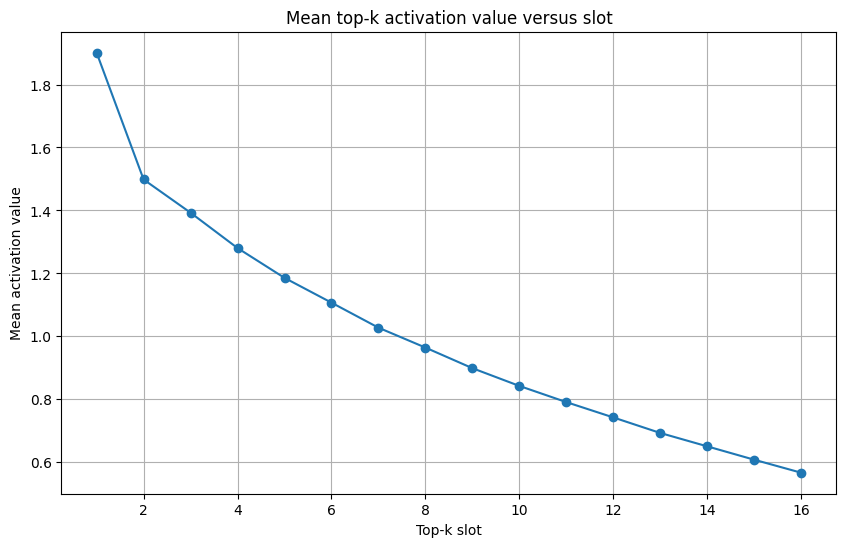

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
mean_topk_per_slot = topk_values.float().mean(dim=0)  # mean over pages, for each topk slot
plt.plot(range(1, topk + 1), mean_topk_per_slot, marker='o')
plt.xlabel("Top-k slot")
plt.ylabel("Mean activation value")
plt.title("Mean top-k activation value versus slot")
plt.grid(True)
plt.show()